# Transformers - How things came to here!

Several years back, before deep learning taking a massive outbreak most of the natural language processing tasks were stuck at a very primitive level. After the DL initial usages, RNNs and CNNs came into the scene and improved the models we used to do the NLP tasks greatly. But none of them affected the NLP world as the Transformers architecture which was introduced by a google researcher team.

In early days of NLP, Markov decision processes, markov models, chains were used to predict the next element of a sequence given the past elements. Then these turned into the space of CNNs. But CNNs have the drawback of not keeping track of sequences in long/complex inputs. Then came the RNNs and LSTMs to mitigate the above issues which can keep a state within. 

After all those, in 2017 google research/brain scientists published a paper `Attention is all you need` which introduces the architecture of Transformers. 

For the moment I will not go in to the details of the model architecture of the original transformer. But important point to know is attention mechanism replaced the recurrence which need to have high computational power to keep details of long sequences. Instead attention is a `word to word` operation. The attention mechanism will find how each word is related to each other including itself. Therefore it can provide deeper relationships between words and produce better results.

<center><image src="imgs/1.png" width="400"/></center>

Normal Transformer architecture consists with 2 major parts encoder and decoder. Usually these part consists of stacks of layers.

### **Encoder stack**

The original transformer's encoder stack consists of 6 layers of below stucture.

<center><image src="imgs/2.jpg" width="200"/></center>

Each of above like structure contains 2 sub layers: a multiheaded attention mechanism and a fully connected(dense) position-wise feedforward network. Also note the residual connections (skip connections) in each such sublayers. This make sure all the key information such as positional encoding is not lost on the way. (Note Embedding is only available to the first one.)

#### **Input Embedding**

In the original paper this is of size 512. As with any other model embedding layer, usage of this is pretty simple. Assume we have a sentence like below.

<center>My name is Dilan and I am a software engineer.</center>

Then we need to tokenize it.

<center>[My, name, is, Dilan, and, I, am, a, software, engineer, .]</center>

Since we cant use text in processes, we will assign integer values for each token.

<center>[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]</center>

Then using these integers we can define a vocabulary and move in to embedding training. To do that we define a (vocabulary size * predefined width) sized matrix as embedding matrix. Then we use it in the first section of NLP model. To see a example implementation check this [Jupyter Notebook of Mine](https://github.com/DinushkaDDS/DL-models-from-Scratch/blob/master/sentence%20embedding.ipynb).

We can use such pretrained embedding layer as the input embedding to a transformer as well. But transformers are based on dynamic embeddings. Which means embedding are trained on the fly.

One problem in using regular/old methods of word embeddings is that they do not contain any positional data. Therefore some words may be unnecessarily similar mathamatically even though they cant be language wise or vice versa. To solve that problem original transformer model team introduced a new technique called `positional encoding`.


##### Positional Encoding

Positional Encoding is the method used to provide the position of a word in a sequence. Having additional vectors to keep positional details is not practical as it makes things complicated computational and architectural wise. Instead, we can add positional encoding to the input embeddings.

But to do that we need to make the position encodings to the same size as of the word embeddings. As a solution to the mentioned problem they found a way to use sine and cosine values that will remain small yet useful.

<center><image src="imgs/3.jpg" width="300"/></center>

In here for odd numbers and even numbers researchers have defined 2 formulas. There are some other techniques to do this as well. But this is the one used by the original transformer team. Code implementation of above to get positional embeddings is as follows.


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import math

def positional_encodings(considering_pos, vector_width=512):

    positional_encoding_vector = np.zeros((vector_width))
    for i in range(0, vector_width, 2):

        positional_encoding_vector[i] = \
                                math.sin(considering_pos/(10000**((2*i)/vector_width)))
        positional_encoding_vector[i+1] = \
                                math.cos(considering_pos/(10000**((2*i)/vector_width)))

    return positional_encoding_vector


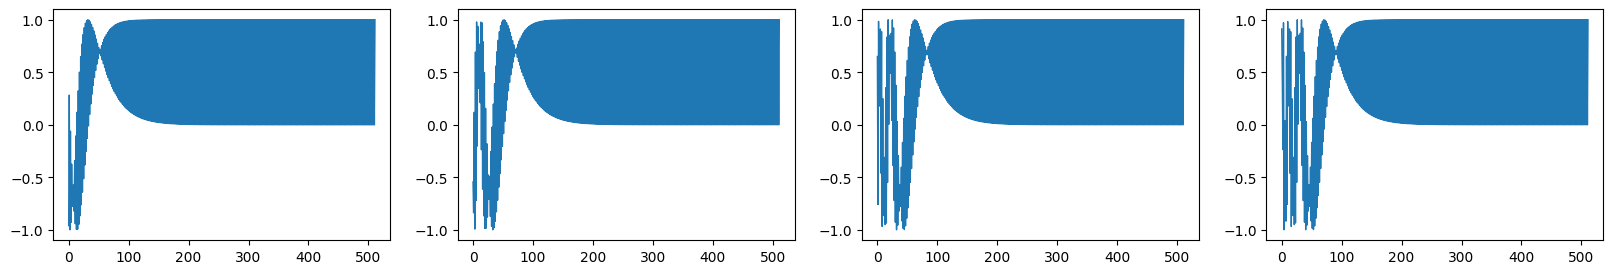

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))

for i in range(4):
    embeddings = positional_encodings((i+1)*5, 512)
    ax[i].plot(range(512), embeddings, linewidth=1)

As you can this is a very interesting approach to get a positional encoding for a given position. The above function returns a vector with the same dimension as the word embedding but unique for each position.

In [5]:
from scipy.spatial.distance import cosine

1- cosine(positional_encodings(1), positional_encodings(10))

0.8485685095237376

In [6]:
1- cosine(positional_encodings(1), positional_encodings(2))

0.9860638318260113

As you can see higher the distance between the positions, higher the difference would in terms of encodings. So now we have a meaningful way to represent the positional details in vector form.

Now to include these details to the actual word embeddings transformers researchers simply added them together. But this causes issues like actual word meanings get diminished compared to the positional value. To mitigate that we can do some kind of transformation before adding them (eg. Squarerooting, weighted adding etc.) Below is an example implementation of the squarerooted adding.

In [7]:
def positional_embeddings(positional_vector, word_vector, vector_width=512):
    out = np.array(positional_vector.shape)

    for i in range(len(positional_vector)):
        out[i] = positional_vector[i] + word_vector[i]*math.sqrt(vector_width)
    
    return

As we can see the value of word vector has been amplified by a constant value so that, its information get more importance compared to the positional vector in general.

Those techniques fullfill the task of generating meaningful embedding for the words. And it's output will next move to the `Multi Head Attention` sub layer.


#### **Multi Head Attention**

The output of the positionally encoded word embedding will come to this part next. Its general structure include a post layer normalization, a skip connection as well.

<center><image src="imgs/4.jpg" width="300"/></center>

Before going further it is important to understand the idea and architecture behind multi head attention.

##### Architecture

In simple terms attention mechanism allows an input to interact with each other(including itself) and find out who should it pay more attention to. The outputs from attention mechanisms are those interactions and attention scores.

But there's a concern. Model would only get one timestep at a time. Also to check the interactions with each of the other words in would take considerable amount of time. To solve that input embeddings will get divided in to smaller dimensions(if vector width is 512 then can be divided into 8*64 sized vectors). Then we can do the calculations in parallel for each divided dimension. This is where the multihead part is coming to the naming. 

And there's few processing would get done in the each of those heads to identify how each embedding is related to each other in a given sequence. Ultimately output of each of these heads would be (size of the sequence * divided dim size).

For example assume the sequence 'My name is Dilan Dinushka and I am an engineer' and embedding size 4. Then this would yield (9, 4) matrix. If we define 4 heads in attention, then each head would get (9, 1) sized input and should output the same size(not essential though). 

Then before sending the processed output to next step we need to combine everything together, so the final output from the multihead attention would be Z = (z1, z2, ......., zn) where zi indicate the output from the ith head(in our previous example this final output would be then (9, 4) dimension again as per the original transformer implementation).


Now lets move on to the each attention heads inner workings. Inside of the each head of attention mechanism have 3 representations of each word vector passed to it.

- **Q** : A Query vector that has a dimension of head_width and get trained when a word vector xi seeks all of the key value pairs of other word vectors.

- **K** : A Key vector that has a dimension of head_width which will be trained to give an attention formula value.

- **V** : A Value vector that has same dimension as above ones which will be trained to provide another attention formula value.

It should be noted that Attention is a function defined as `Scaled Dot-Product Attention` in the original transformer architecture. Its mathematical form is as below.


<center><image src="imgs/5.jpg" width="300"/></center>


> Vectors having same dimensions help when getting the dot product. Otherwise it ok to define dimensions that would satisfy the dot product constraints. Also this is what was used in the original transformers paper. (And at the moment that is what we are studying)


Now how to get the Q, K and V vectors. Thats where the weight matrices Qw, Kw and Vw comes in to play. In original transformer model their dimensions are 64 * 512 (head_width*embedding_size). Anyway the idea is that given the sequence of word vectors (x) getting dot product of it with any of the weight matrices should yield the corresponding representational vector.

    x dot_product Qw ==> Q vector

    Below are the related dimensional details.

    (sequence_length * embedding_size) * (embedding_size * head_width) ==> (sequence_length*head_width)


So this way weight matrices can be in fixed size while sequence length(x) sizes change.

With the above details in mind, lets look at a basic implementation of attention mechanism.

In [8]:
# Assume X is a dataset with vector width(Embedding size) of 4 and sequence size of 3.
x = np.array(
    [[1, 0, 1, 0],
     [0, 2, 0, 2],
     [1, 1, 1, 1]]
)

Then we need to define the weight matrices Qw, Kw and Vw. Since Embedding size is 4 in our case each of these matrices should have 4 number of rows. We will define the column sizes to 3.

In [9]:
# Query Weight Matrix
Qw = np.array([[1, 0, 1],
               [1, 0, 0],
               [0, 0, 1],
               [0, 1, 1]])

# Key Weight matrix
Kw = np.array([[0, 0, 1],
               [1, 1, 0],
               [0, 1, 0],
               [1, 1, 0]])

# Values Weight matrix
Vw = np.array([[0, 2, 0],
               [0, 3, 0],
               [1, 0, 3],
               [1, 1, 0]])

Once we have the weight matrices we can calculate the Q, K and V representations for each word. To do that, we need to get the dot product of input matrix and weight matrices as below.

In [10]:
Q = np.dot(x, Qw)
K = np.dot(x, Kw)
V = np.dot(x, Vw)

The Q, K and V matrices include the respective representations of each word.

Then we can calculate the attention value for each of the words compared to each other. In attention value we multiply the query value of one word with each of the Key vectors.

In [11]:
Q[0]@K[0] # This represents the attention value between the first word and its key
Q[0]@K[1] # This represents the attention value between the first word and second key

4

So we can calculate such attention values for each word query by taking the matrix dot product with Key matrix. (Also here we have scaled it with the dimension of the embedding vecor as well.)

In [12]:
scaled_attention = np.dot(Q, K.T)/(int(3**0.5))
scaled_attention

array([[ 2.,  4.,  4.],
       [ 4., 16., 12.],
       [ 4., 12., 10.]])

Using the above we can calculate the softmax applied attention for each vector. Below values can be considered as the attention scores among each of the words in the considering sequence.

In [13]:
from scipy.special import softmax

attention_scores = softmax(scaled_attention, axis=1)
attention_scores

array([[6.33789383e-02, 4.68310531e-01, 4.68310531e-01],
       [6.03366485e-06, 9.82007865e-01, 1.79861014e-02],
       [2.95387223e-04, 8.80536902e-01, 1.19167711e-01]])

The above represent the attention scores for the each of the initial 3 embeddings we define compared to each other.

Then comes the place where we need to calculate the values related to each of the inputs. To do that we have to multiply the each of the attention scores with their respective representative Value (V) vector.

This is bot confusing compared to previous tasks. So heres a sample example. Assume for a word in our sequence we got attention score vector '[ 1, 2, 4]'. These values represent how much weightage the value representations from the word sequence should provide. Check the below code.

In [27]:
weighted_score_w1_w1 = attention_scores[0][0]* V[0]
weighted_score_w1_w2 = attention_scores[0][1]* V[1]
weighted_score_w1_w3 = attention_scores[0][2]* V[2]
weighted_score_w1 = np.stack((weighted_score_w1_w1, 
                                    weighted_score_w1_w2, 
                                    weighted_score_w1_w3), axis=0)
weighted_score_w1

array([[0.06337894, 0.12675788, 0.19013681],
       [0.93662106, 3.74648425, 0.        ],
       [0.93662106, 2.80986319, 1.40493159]])

Above calculations is just for the first vector of the attention score matrix.

Then we need to take the element wise summation for the above list of vectors to get the actual output. This yields the attention based output value vector for the selected word vector.

In [66]:
output_w1 = weighted_score_w1.sum(axis=0)
output_w1 # This is the output related to the Vector 1.

array([1.93662106, 6.68310531, 1.59506841])

WAs we mention earlier this is only for one word vector. We need to calculate the weighted_scores and outputs for other vectors in the attention score matrix in the same way. Since manually taking attention weights and multiplying it with the value vectors is time consuming, we can do it in a vectorized manner as below.

In [67]:
weighted_scores = np.expand_dims(attention_scores, axis=2)*V # Note the elementwise multiplication
weighted_scores

array([[[6.33789383e-02, 1.26757877e-01, 1.90136815e-01],
        [9.36621062e-01, 3.74648425e+00, 0.00000000e+00],
        [9.36621062e-01, 2.80986319e+00, 1.40493159e+00]],

       [[6.03366485e-06, 1.20673297e-05, 1.81009946e-05],
        [1.96401573e+00, 7.85606292e+00, 0.00000000e+00],
        [3.59722029e-02, 1.07916609e-01, 5.39583043e-02]],

       [[2.95387223e-04, 5.90774446e-04, 8.86161669e-04],
        [1.76107380e+00, 7.04429521e+00, 0.00000000e+00],
        [2.38335422e-01, 7.15006266e-01, 3.57503133e-01]]])

In [70]:
output = weighted_scores.sum(axis=1)
output

array([[1.93662106, 6.68310531, 1.59506841],
       [1.99999397, 7.9639916 , 0.05397641],
       [1.99970461, 7.75989225, 0.35838929]])

Below is the combinations of everything we did so far in one function.

Also note that this is one mechanism of calculating the attention values. Instead of calculating weighed scores sum, we can directly multiply the attention_scores with Value(V) matrix as well.

In [72]:
def calc_attention(Q, W, V, k_d):
    '''
    Here Q, W and V are matrices that comes after multiplication with
    input sequence matrix.

    k_d = embedding width
    '''
    temp = np.dot(Q, K.T)/(int(k_d**0.5))
    attention_scores = softmax(temp, axis=1)
    weighted_scores = np.expand_dims(attention_scores, axis=2)*V
    attention_output = weighted_scores.sum(axis=1)
    return attention_output


att_val = calc_attention(Q, K, V, 3)
att_val

array([[1.93662106, 6.68310531, 1.59506841],
       [1.99999397, 7.9639916 , 0.05397641],
       [1.99970461, 7.75989225, 0.35838929]])

As a wrap up remember we had a input sequence with length 3, and each had size 4 embedding (So 3x4 matrix). Above reflect what happen to this input matrix inside of a attention layer (more specifically in the original transformer attention layer).

>There are several ways to calculate attention other than the one we used here. Read about them if interested!

Now if we go back to where we started this mess, we were discussing the attention mechanism in the original transformers. And we said that it have some special technique called multiheaded attention which basically means input get splitted from its embedding dimension and attention operation will get applied separetely. So how the attention applied values get combined after the split?

To see this from here onwards lets assume that we are having 3x64 sized outputs from each heads.

In [76]:
# random values to represent the output values from 8 attention heads.
head_out1 = np.random.random((3, 64))
head_out2 = np.random.random((3, 64))
head_out3 = np.random.random((3, 64))
head_out4 = np.random.random((3, 64))
head_out5 = np.random.random((3, 64))
head_out6 = np.random.random((3, 64))
head_out7 = np.random.random((3, 64))
head_out8 = np.random.random((3, 64))

Assuming above are the outputs from 8 attention heads we can combine them by concatenating them. But in the original implementation there's a weight matrix that get added to the concataneted output.

In [81]:
attention_output = np.hstack((head_out1,
                                  head_out2,
                                  head_out3,
                                  head_out4,
                                  head_out5,
                                  head_out6,
                                  head_out7,
                                  head_out8))
attention_output

array([[0.50797615, 0.96253788, 0.40681692, ..., 0.56499623, 0.57256347,
        0.55260343],
       [0.56447982, 0.90030537, 0.02743779, ..., 0.66184638, 0.60194478,
        0.54083157],
       [0.07001466, 0.48846472, 0.05417758, ..., 0.1667208 , 0.32225329,
        0.58818299]])

So all the operations related to attention block is now done! 

Then this output will be moved to post-layer normalization.


#### **Post Layer Normalization (Post-LN)**


The output from the attention layer will then move in to here.

<center><image src="imgs/6.jpg" width="200"/></center>

Basically what this sub block does this adding the residual connection coming from the beginning of the sublayer (in this case before the attention part. Check the diagram for clarity) to the output of the attention part.

        LayerNorm( x + Sublayer(x))

Here sublayer part refers the output of the sublayer.

When considering the normalization methods, there are many and it changes from model to model. But basic one can be defined as below.

<center><image src="imgs/7.jpg" width="300"/></center>

        Here, 
                μ = mean
                σ = standard deviation
                γ = scaling parameter
                β = bias vector

Once we do the normalization then the all the processing related to the first sub layer will be completed. Then comes the second sub layer of the attention module.

#### **Feedforward Network**

The input to this sub section is the output from the normalization layer.

<center><image src="imgs/8.jpg" width="200"/></center>

The Feedforward network in both encoder and decoder stacks are straightforward compared to the attention parts.

        They are fully connected.
        It contains 2 layers and applies a ReLu funtions.
        Input/ Output is 512, hidden layer contain 2048 neurons.

Output from the FF Network then goes through a Post LN part as before. Then output can either go to another layer of encoder stack or to the decoder stack.

### **Decoder Stack**

Decoder part of transformer network contains stacks of layers same as the encoder. Each of such layer would have the following structure.


<center><image src="imgs/9.jpg" width="200"/></center>


As we can see each layer of the decoder contains 3 sublayers. Feed forward, Multihead Attention and Masked Multihead Attention are those sublayers.

Out of those 3, first 2 feedforward and multihead attention sublayers are same as the encoder stack. But the third one is bit different.

Masked Multihead attention layer has special function where from a given position rest of the word embeddings will get masked. This causes the model to base it's inference without seeing the complete sequence.

Also just like the encoder stack there are residual(skip) connections surrounding the 3 sublayers as well. Other than that, all the sublayer outputs including the emebedding layer output have the same dimension size.

Since most of the parts are similar we will not discuss more about those parts. Instead we will focus on the differences in the decoder compared to the encoder stack.


> The current transformer model we are discussing is used for language translations task. And therefore we will discuss the transformer functionality in that sense.

#### **Output Embeddings & Positional Encodings**

As initial transformer was used in a language translational task, its expected output is another language. So that part also needed to be embedded before using. And that's where the decoder stack's embedding layer (named Output embedding) comes in to play. It does the exact same thing as the encoder layer along with a similar positional encoding.

#### **Attention layers**

> Transformer decorders are of an auto-regressive type model. It means it uses its previous outputs as a part of input for the next iterations. 

The decoder's masked multihead attention layer only let the attention happen to positions up to and including the current cosidering position. Basically it means when calculating the attention, it does not get to see the full sequence (In practical sense not allowing the model to see into future in terms of output). 

From there onward, multi-head attention layers also only use the positions not masked by the previous layer (means only up to the current position transformer is predicting) to avoid seeing the sequence it should predict ideally.

This masking function is simply for making the training process parallel. Otherwise we will need to sequentially run the examples through the decoding network. And infact that's how transformers work in inference phase in some cases.

What masking function does is it helps the model to mimic the sequential behaviour while in the training phase by covering the words in the sequence.


<center><image src="imgs/10.png" width="200"/></center>


So in the decoder attention,

    for first sequence input => encoder output
    for second sequence input => encoder output + prediction from the first part
    .....
    
so on until the sequence is completed (this is why it is called autoregressive model since predictions in the previous runs are being considered for next runs.)

To achieve this we are adding a mask matrix with negative infinity values as outlined in the above image to the scaled scores matrix. This causes the matrix to yield 0 values in require places after the softmax function. This is super interesting technique used in transformers!
S
For further clarifications about the transformer layers, read these excellent explanations.

[Medium Article on Transformers](https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0)

[Stackoverflow Answer](https://stackoverflow.com/questions/58127059/how-to-understand-masked-multi-head-attention-in-transformer)



Another important point is that, this decoder's multihead attention layer uses Key and Value (K, V) values from the encoder and Query (Q) values from the masked multihead attention layer. 

After those layers it goes to the Feedforward network(FFN), a post layer normalization task and then a linear layer before classification. In NLP this is a very large layer with the size of vocabulary.

And thats it! Thats is the basic architecture of the original transformer. It is bit complicated when implementing in practice. But it solved lots of problem existed in previous models used for sequencial tasks such as RNNs, GRUs, LSTMs etc.

But unless you are a researcher it is highly unlikely you will need to implement a transformer from scratch! And to be honest it is bit complicated and time consuming to implement even using a modern ML framework. Not to mention the computational resources needed and comlexities invloving using multiple GPUs.

Instead we can use huggingface transformers for most of our usecases. It is easy and straight forward to use.!

    pip install transformers